In [1]:
#https://drive.google.com/file/d/1KENM6BW5UjRoSjnWmuBP_MS_NrC0cefP/view?usp=sharing

FILEID = "1KENM6BW5UjRoSjnWmuBP_MS_NrC0cefP"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O tanjiro.jpeg && rm -rf /tmp/cookies.txt

--2025-10-28 20:06:36--  https://docs.google.com/uc?export=download&confirm=&id=1KENM6BW5UjRoSjnWmuBP_MS_NrC0cefP
Resolving docs.google.com (docs.google.com)... 172.217.194.100, 172.217.194.102, 172.217.194.138, ...
Connecting to docs.google.com (docs.google.com)|172.217.194.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1KENM6BW5UjRoSjnWmuBP_MS_NrC0cefP&export=download [following]
--2025-10-28 20:06:37--  https://drive.usercontent.google.com/download?id=1KENM6BW5UjRoSjnWmuBP_MS_NrC0cefP&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 64.233.170.132, 2404:6800:4003:c1a::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|64.233.170.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6476 (6.3K) [image/jpeg]
Saving to: ‘tanjiro.jpeg’

tanjiro.jpeg        100%[===================>]   6.32K  --.-KB/s    in 0s  

### Imagen Original

(125, 125, 3)

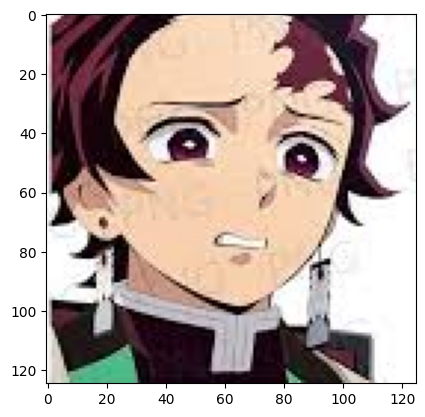

In [2]:
import os
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
image = imread(os.path.join("tanjiro.jpeg"))
image = image[50:175,50:175,:]
plt.imshow(image)
image.shape

In [3]:
X = image.reshape(-1, 3)
r,c,ch = image.shape
print(r,c,ch)

125 125 3


In [4]:
vr = np.linspace(0,r,r,endpoint=False)
vc = np.linspace(0,c,c,endpoint=False)
Xc = np.kron(np.ones((r,1)),vc.reshape(-1,1))
Xr = np.kron(vr.reshape(-1,1),np.ones((1,c)))
Xc = Xc.reshape(-1)
Xr = Xr.reshape(-1)
X = np.c_[X,Xc,Xr]
X.shape

(15625, 5)

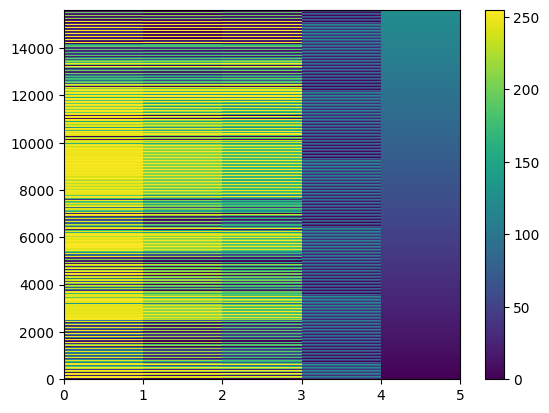

In [5]:
plt.pcolormesh(X)
plt.colorbar()
plt.show()

### Ejercicios:

1. Realice una comparación de los métodos de clustering vistos, para generar una segmentación de imagen a color, incluyendo la información de ubicación de cada pixel (ver Cuaderno guía [tanjiro](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/4_Clasificacion_Clustering_DR/tanjiro.ipynb)). Varie la cantidad de grupos (niveles o clases de segmentación) $k\in\{3,5,7,9\}$ y presente los scores de inercia y silueta conseguidos.


## K-means


Processing k = 3 with cuML KMeans
Silhouette Score for k=3: 0.4702
Inertia for k=3: 68630772.70

Processing k = 5 with cuML KMeans
Silhouette Score for k=5: 0.3885
Inertia for k=5: 49758097.55

Processing k = 7 with cuML KMeans
Silhouette Score for k=7: 0.4181
Inertia for k=7: 33659265.59

Processing k = 9 with cuML KMeans
Silhouette Score for k=9: 0.4262
Inertia for k=9: 28991330.21


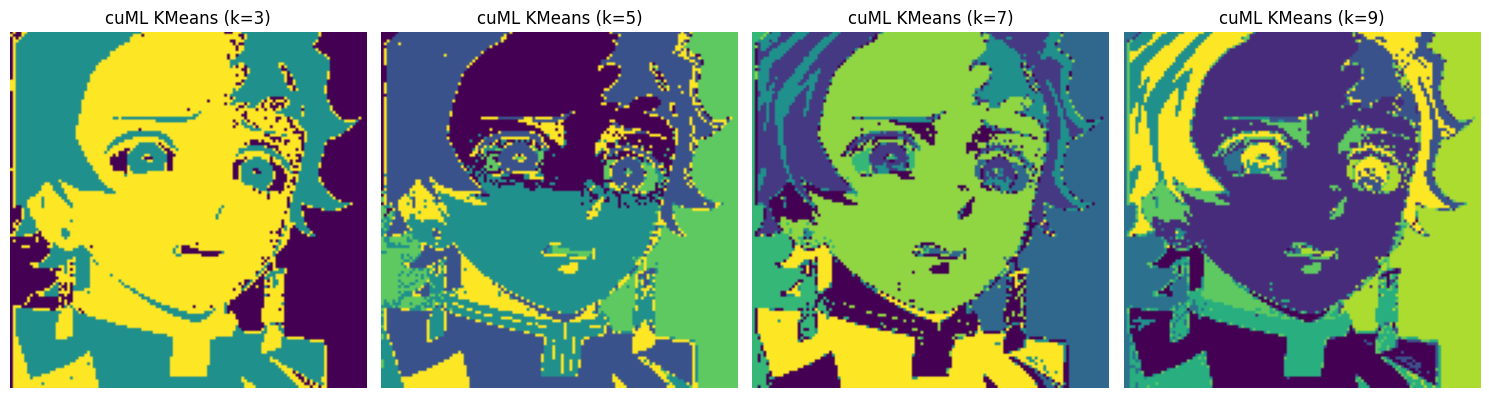


cuML KMeans Clustering Scores:
k=3: Inertia=68630772.70, Silhouette Score=0.47
k=5: Inertia=49758097.55, Silhouette Score=0.39
k=7: Inertia=33659265.59, Silhouette Score=0.42
k=9: Inertia=28991330.21, Silhouette Score=0.43


In [6]:
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
from cuml.cluster import KMeans as cuKMeans
from cuml.metrics.cluster import silhouette_score as cu_silhouette_score # Corrected import path
# Inertia calculation might need a custom approach with CuPy/cuML

r, c, ch = image.shape
k_values = [3, 5, 7, 9]
kmeans_rapids_scores = {}

# Convert data to CuPy array
X_gpu = cp.asarray(X)

# Create a figure and a set of subplots for visualization
fig, axes = plt.subplots(1, len(k_values), figsize=(15, 5))

for i, k in enumerate(k_values):
    print(f"\nProcessing k = {k} with cuML KMeans")
    # Initialize and fit cuML KMeans
    kmeans = cuKMeans(n_clusters=k, random_state=42) # cuML KMeans does not have init='k-means++', n_init='auto' in this version
    y_pred = kmeans.fit_predict(X_gpu)

    # Calculate inertia
    # cuML KMeans doesn't directly expose inertia in the same way as sklearn.
    # A common way to calculate inertia is the sum of squared distances
    # of samples to their closest cluster center.
    # We'll calculate this manually using CuPy.
    centroids = kmeans.cluster_centers_
    # Expand dimensions for broadcasting
    expanded_X = cp.expand_dims(X_gpu, axis=1)
    expanded_centroids = cp.expand_dims(centroids, axis=0)
    # Calculate distances to all centroids
    distances = cp.sum((expanded_X - expanded_centroids)**2, axis=2)
    # Find the minimum distance for each point (distance to its assigned centroid)
    # Need to select distances based on assigned labels
    assigned_distances = cp.sum((X_gpu - centroids[y_pred])**2, axis=1)
    inertia = cp.sum(assigned_distances)


    # Calculate and store silhouette score using cuML's silhouette_score
    y_pred_gpu = cp.asarray(y_pred) # Ensure labels are on GPU for cuML
    silhouette_avg = None
    if len(cp.unique(y_pred_gpu)) > 1 and len(y_pred_gpu) > 1:
        silhouette_avg = cu_silhouette_score(X_gpu, y_pred_gpu)
        kmeans_rapids_scores[k] = {'inertia': float(inertia), 'silhouette_score': float(silhouette_avg)} # Convert CuPy scalars to float
        print(f"Silhouette Score for k={k}: {silhouette_avg:.4f}")
    else:
        print(f"Cannot calculate Silhouette Score for k={k} with {len(cp.unique(y_pred_gpu))} clusters and {len(y_pred_gpu)} samples.")
        kmeans_rapids_scores[k] = {'inertia': float(inertia), 'silhouette_score': None}

    print(f"Inertia for k={k}: {inertia:.2f}")


    # Reshape cluster labels back into image dimensions (convert back to NumPy for matplotlib)
    Ilabels = cp.asnumpy(y_pred).reshape(r, c)

    # Display the segmented image in the corresponding subplot
    ax = axes[i] if len(k_values) > 1 else axes
    ax.imshow(Ilabels, cmap='viridis') # Use a colormap for labels
    ax.set_title(f'cuML KMeans (k={k})')
    ax.axis('off')

plt.tight_layout()
plt.show()

print("\ncuML KMeans Clustering Scores:")
for k, score_data in kmeans_rapids_scores.items():
    silhouette_str = f"{score_data['silhouette_score']:.2f}" if score_data['silhouette_score'] is not None else 'N/A'
    print(f"k={k}: Inertia={score_data['inertia']:.2f}, Silhouette Score={silhouette_str}")

## DBSCAN


Processing with cuML DBSCAN for eps=5, min_samples=5
Number of clusters found by cuML DBSCAN: 176
Silhouette Score for eps=5, min_samples=5: -0.1785

Processing with cuML DBSCAN for eps=10, min_samples=5
Number of clusters found by cuML DBSCAN: 76
Silhouette Score for eps=10, min_samples=5: -0.0734

Processing with cuML DBSCAN for eps=10, min_samples=10
Number of clusters found by cuML DBSCAN: 42
Silhouette Score for eps=10, min_samples=10: 0.0790

Processing with cuML DBSCAN for eps=15, min_samples=10
Number of clusters found by cuML DBSCAN: 22
Silhouette Score for eps=15, min_samples=10: -0.1656


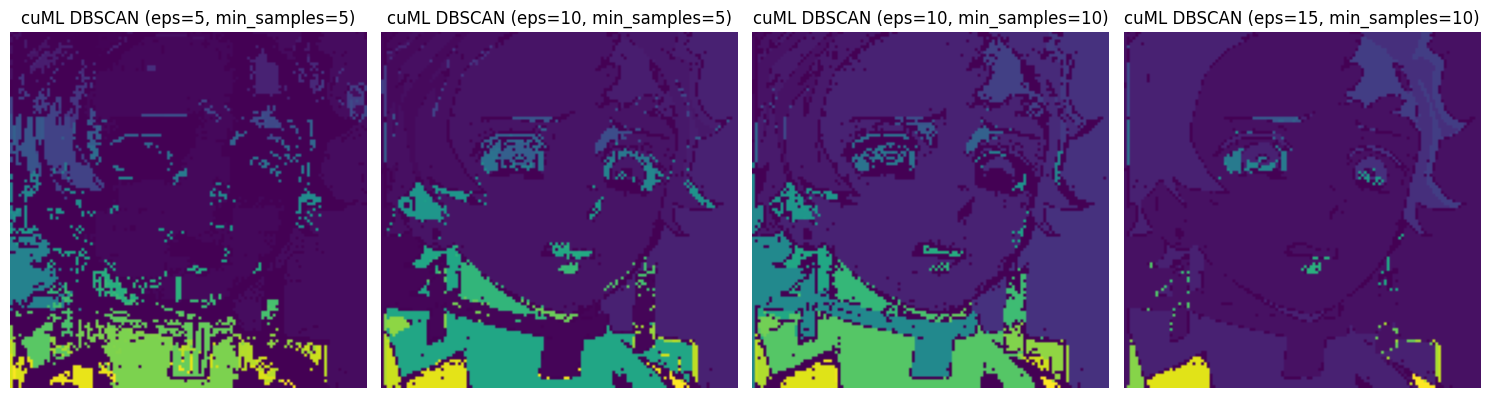


cuML DBSCAN Clustering Scores:
eps=5, min_samples=5: Number of Clusters=176, Silhouette Score=-0.18
eps=10, min_samples=5: Number of Clusters=76, Silhouette Score=-0.07
eps=10, min_samples=10: Number of Clusters=42, Silhouette Score=0.08
eps=15, min_samples=10: Number of Clusters=22, Silhouette Score=-0.17


In [7]:
from cuml.cluster import DBSCAN as cuDBSCAN
from cuml.metrics.cluster import silhouette_score as cu_silhouette_score
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt

# Define different parameter combinations for DBSCAN
param_combinations = [
    {'eps': 5, 'min_samples': 5},
    {'eps': 10, 'min_samples': 5},
    {'eps': 10, 'min_samples': 10},
    {'eps': 15, 'min_samples': 10}
]

dbscan_scores = {}
r, c, ch = image.shape

# Convert data to CuPy array
X_gpu = cp.asarray(X)


# Create a figure and a set of subplots for visualization
fig, axes = plt.subplots(1, len(param_combinations), figsize=(15, 5))


for i, params in enumerate(param_combinations):
    eps = params['eps']
    min_samples = params['min_samples']
    print(f"\nProcessing with cuML DBSCAN for eps={eps}, min_samples={min_samples}")

    dbscan = cuDBSCAN(eps=eps, min_samples=min_samples)
    y_pred_dbscan = dbscan.fit_predict(X_gpu)

    # Get the number of clusters found by DBSCAN (ignoring noise, labeled as -1)
    n_clusters_dbscan = len(cp.unique(y_pred_dbscan)) - (1 if -1 in cp.unique(y_pred_dbscan) else 0)
    print(f"Number of clusters found by cuML DBSCAN: {n_clusters_dbscan}")

    # Calculate silhouette score, excluding noise points (-1 labels)
    # Convert labels back to CuPy if needed for cuML silhouette_score
    y_pred_dbscan_gpu = cp.asarray(y_pred_dbscan)
    unique_labels = cp.unique(y_pred_dbscan_gpu)
    labels_without_noise = [label for label in unique_labels if label != -1]

    silhouette_avg = None
    if len(labels_without_noise) > 1:
        # Get indices of non-noise points
        non_noise_indices = cp.where(y_pred_dbscan_gpu != -1)[0]
        if len(non_noise_indices) > 1:
            # Need to ensure both X_gpu and y_pred_dbscan_gpu are filtered
            silhouette_avg = cu_silhouette_score(X_gpu[non_noise_indices], y_pred_dbscan_gpu[non_noise_indices])
            dbscan_scores[(eps, min_samples)] = {'n_clusters': n_clusters_dbscan, 'silhouette_score': float(silhouette_avg)} # Convert CuPy scalar to float
            print(f"Silhouette Score for eps={eps}, min_samples={min_samples}: {silhouette_avg:.4f}")
        else:
             print(f"Cannot calculate Silhouette Score for eps={eps}, min_samples={min_samples}: Not enough non-noise samples ({len(non_noise_indices)}).")
             dbscan_scores[(eps, min_samples)] = {'n_clusters': n_clusters_dbscan, 'silhouette_score': None}
    else:
        print(f"Cannot calculate Silhouette Score for eps={eps}, min_samples={min_samples}: Not enough clusters ({len(labels_without_noise)}).")
        dbscan_scores[(eps, min_samples)] = {'n_clusters': n_clusters_dbscan, 'silhouette_score': None}


    # Reshape cluster labels back into image dimensions (convert back to NumPy for matplotlib)
    Ilabels_dbscan = cp.asnumpy(y_pred_dbscan).reshape(r, c)

    # Display the segmented image in the corresponding subplot
    ax = axes[i] if len(param_combinations) > 1 else axes
    ax.imshow(Ilabels_dbscan, cmap='viridis') # Using a colormap to distinguish clusters
    ax.set_title(f'cuML DBSCAN (eps={eps}, min_samples={min_samples})')
    ax.axis('off') # Hide axes


plt.tight_layout() # Adjust layout to prevent overlapping titles
plt.show()


print("\ncuML DBSCAN Clustering Scores:")
for (eps, min_samples), score_data in dbscan_scores.items():
    silhouette_str = f"{score_data['silhouette_score']:.2f}" if score_data['silhouette_score'] is not None else 'N/A'
    print(f"eps={eps}, min_samples={min_samples}: Number of Clusters={score_data['n_clusters']}, Silhouette Score={silhouette_str}")

## Spectral Clustering


Processing with scikit-learn Spectral Clustering for k = 3
Silhouette Score for k=3: 0.4709

Processing with scikit-learn Spectral Clustering for k = 5
Silhouette Score for k=5: 0.3158

Processing with scikit-learn Spectral Clustering for k = 7
Silhouette Score for k=7: 0.3316

Processing with scikit-learn Spectral Clustering for k = 9
Silhouette Score for k=9: 0.3494


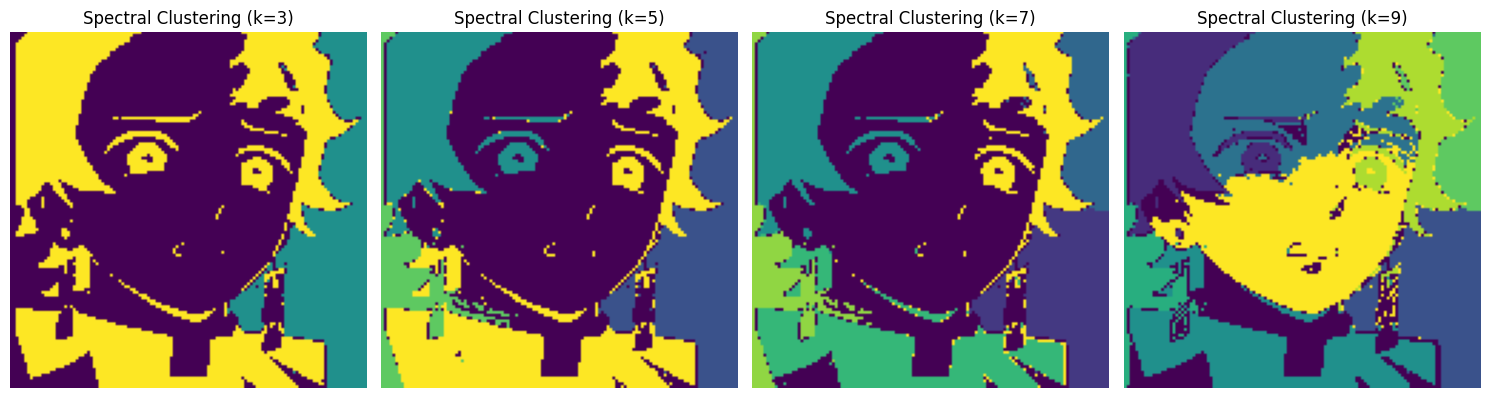


scikit-learn Spectral Clustering Scores:
k=3: Silhouette Score=0.47
k=5: Silhouette Score=0.32
k=7: Silhouette Score=0.33
k=9: Silhouette Score=0.35


In [9]:
#from cuml.cluster import SpectralClustering as cuSpectralClustering # Commented out the problematic import
from sklearn.cluster import SpectralClustering # Use scikit-learn's SpectralClustering
from cuml.metrics.cluster import silhouette_score as cu_silhouette_score # Keep cuML silhouette for potential GPU acceleration if data is on GPU
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt

r, c, ch = image.shape
k_values = [3, 5, 7, 9] # Using the same k values as KMeans for comparison
spectral_scores = {}

# Convert data to CuPy array
X_gpu = cp.asarray(X)

# Create a figure and a set of subplots for visualization
fig, axes = plt.subplots(1, len(k_values), figsize=(15, 5))

for i, k in enumerate(k_values):
    print(f"\nProcessing with scikit-learn Spectral Clustering for k = {k}") # Updated print statement
    # Apply scikit-learn Spectral Clustering
    # Note: cuML SpectralClustering parameters might differ slightly from sklearn
    # Using 'graph' as affinity and 'kmeans' for assign_labels as examples, adjust if needed
    # Using scikit-learn's SpectralClustering now
    spectral = SpectralClustering(
        n_clusters=k,
        assign_labels='discretize', # or 'kmeans'
        random_state=42,
        # cuML SpectralClustering affinity options might be different,
        # check documentation for supported types like 'nearest_neighbors'
        # For now, we'll use the default or a supported one if 'nearest_neighbors' isn't direct
        # If 'nearest_neighbors' requires a precomputed graph, that's an extra step.
        # Let's try with default affinity first or a simple one if available.
        # Based on cuML docs, 'nearest_neighbors' affinity is supported.
        # Using scikit-learn's affinity and n_neighbors
        affinity="nearest_neighbors",
        n_neighbors=10 # Number of neighbors for affinity graph
    )
    # Fit scikit-learn Spectral Clustering on NumPy array (assuming X is a NumPy array)
    # If X_gpu is needed, convert it back to NumPy or use a compatible scikit-learn version with GPU support if available
    # Based on previous cells, X is the NumPy array with added position features
    y_pred_spectral = spectral.fit_predict(np.ascontiguousarray(X)) # Ensure X is contiguous for scikit-learn

    # Calculate silhouette score
    # Using scikit-learn's silhouette_score with NumPy arrays
    from sklearn.metrics import silhouette_score # Import scikit-learn's silhouette_score
    silhouette_avg = None
    # Check if there are more than 1 cluster and more than 1 sample
    if len(np.unique(y_pred_spectral)) > 1 and len(y_pred_spectral) > 1:
        # Check if the number of samples is greater than the number of clusters for silhouette_score
        if len(y_pred_spectral) > k:
             # Use scikit-learn's silhouette_score with the original data X and predictions
            silhouette_avg = silhouette_score(X, y_pred_spectral)
            spectral_scores[k] = {'silhouette_score': float(silhouette_avg)} # Store as float
            print(f"Silhouette Score for k={k}: {silhouette_avg:.4f}")
        else:
            print(f"Cannot calculate Silhouette Score for k={k}: Number of samples ({len(y_pred_spectral)}) must be greater than the number of clusters ({k}).")
            spectral_scores[k] = {'silhouette_score': None}
    else:
        print(f"Cannot calculate Silhouette Score for k={k}: Not enough clusters or samples.")
        spectral_scores[k] = {'silhouette_score': None}


    # Reshape cluster labels back into image dimensions (y_pred_spectral is already NumPy)
    Ilabels_spectral = y_pred_spectral.reshape(r, c)

    # Display the segmented image in the corresponding subplot
    ax = axes[i] if len(k_values) > 1 else axes
    ax.imshow(Ilabels_spectral, cmap='viridis')
    ax.set_title(f'Spectral Clustering (k={k})') # Updated title
    ax.axis('off')


plt.tight_layout()
plt.show()

print("\nscikit-learn Spectral Clustering Scores:") # Updated print statement
for k, score_data in spectral_scores.items():
    silhouette_str = f"{score_data['silhouette_score']:.2f}" if score_data['silhouette_score'] is not None else 'N/A'
    print(f"k={k}: Silhouette Score={silhouette_str}")

In [ ]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

r, c, ch = image.shape
k_values = [3, 5, 7, 9] # Using the same k values as KMeans for comparison
spectral_scores = {}

# Create a figure and a set of subplots for visualization
fig, axes = plt.subplots(1, len(k_values), figsize=(15, 5))

for i, k in enumerate(k_values):
    print(f"\nProcessing with scikit-learn Spectral Clustering for k = {k}")
    # Apply scikit-learn Spectral Clustering
    # You might need to tune the affinity and gamma parameters
    spectral = SpectralClustering(n_clusters=k, assign_labels='discretize', random_state=42)
    y_pred_spectral = spectral.fit_predict(X)

    # Calculate silhouette score
    silhouette_avg = None
    if len(np.unique(y_pred_spectral)) > 1 and len(y_pred_spectral) > 1:
        silhouette_avg = silhouette_score(X, y_pred_spectral)
        spectral_scores[k] = {'silhouette_score': silhouette_avg}
        print(f"Silhouette Score for k={k}: {silhouette_avg}")
    else:
        print(f"Cannot calculate Silhouette Score for k={k}: Not enough clusters or samples.")
        spectral_scores[k] = {'silhouette_score': None}


    # Reshape cluster labels back into image dimensions for visualization
    Ilabels_spectral = y_pred_spectral.reshape(r, c)

    # Display the segmented image in the corresponding subplot
    ax = axes[i] if len(k_values) > 1 else axes
    ax.imshow(Ilabels_spectral, cmap='viridis')
    ax.set_title(f'Spectral Clustering (k={k})')
    ax.axis('off')


plt.tight_layout()
plt.show()

print("\nscikit-learn Spectral Clustering Scores:")
for k, score_data in spectral_scores.items():
    silhouette_str = f"{score_data['silhouette_score']:.2f}" if score_data['silhouette_score'] is not None else 'N/A'
    print(f"k={k}: Silhouette Score={silhouette_str}")


Processing with scikit-learn Spectral Clustering for k = 3


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [ ]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

r, c, ch = image.shape
k_values = [3, 5, 7, 9] # Using the same k values as KMeans for comparison
spectral_scores = {}

# Create a figure and a set of subplots for visualization
fig, axes = plt.subplots(1, len(k_values), figsize=(15, 5))

for i, k in enumerate(k_values):
    print(f"\nProcessing with scikit-learn Spectral Clustering for k = {k}")
    # Apply scikit-learn Spectral Clustering with specified parameters
    spectral = SpectralClustering(
        n_clusters=k,
        assign_labels='discretize', # or 'kmeans' as in your example
        random_state=42,
        affinity="nearest_neighbors", # Using nearest neighbors affinity
        n_neighbors=10 # Number of neighbors for affinity graph
    )
    y_pred_spectral = spectral.fit_predict(X)

    # Calculate silhouette score
    silhouette_avg = None
    # Check if there are more than 1 cluster and more than 1 sample
    if len(np.unique(y_pred_spectral)) > 1 and len(y_pred_spectral) > 1:
        # Check if the number of samples is greater than the number of clusters for silhouette_score
        if len(y_pred_spectral) > k:
            silhouette_avg = silhouette_score(X, y_pred_spectral)
            spectral_scores[k] = {'silhouette_score': silhouette_avg}
            print(f"Silhouette Score for k={k}: {silhouette_avg}")
        else:
            print(f"Cannot calculate Silhouette Score for k={k}: Number of samples ({len(y_pred_spectral)}) must be greater than the number of clusters ({k}).")
            spectral_scores[k] = {'silhouette_score': None}
    else:
        print(f"Cannot calculate Silhouette Score for k={k}: Not enough clusters or samples.")
        spectral_scores[k] = {'silhouette_score': None}


    # Reshape cluster labels back into image dimensions for visualization
    Ilabels_spectral = y_pred_spectral.reshape(r, c)

    # Display the segmented image in the corresponding subplot
    ax = axes[i] if len(k_values) > 1 else axes
    ax.imshow(Ilabels_spectral, cmap='viridis')
    ax.set_title(f'Spectral Clustering (k={k})')
    ax.axis('off')


plt.tight_layout()
plt.show()

print("\nscikit-learn Spectral Clustering Scores:")
for k, score_data in spectral_scores.items():
    silhouette_str = f"{score_data['silhouette_score']:.2f}" if score_data['silhouette_score'] is not None else 'N/A'
    print(f"k={k}: Silhouette Score={silhouette_str}")

In [ ]:
import pandas as pd
import numpy as np

# Prepare data for the comparison table
comparison_data = []

# Add KMeans RAPIDS scores
for k, scores in kmeans_rapids_scores.items():
    comparison_data.append({
        'Method': 'K-Means (RAPIDS)',
        'Parameters': f'k={k}',
        'Inertia': scores['inertia'],
        'Silhouette Score': scores['silhouette_score']
    })

# Add DBSCAN RAPIDS scores
for params, scores in dbscan_scores.items():
    # DBSCAN does not have inertia
    comparison_data.append({
        'Method': 'DBSCAN (RAPIDS)',
        'Parameters': f'eps={params[0]}, min_samples={params[1]}',
        'Inertia': 'N/A', # DBSCAN does not have inertia
        'Silhouette Score': scores['silhouette_score']
    })

# Add Spectral Clustering scikit-learn scores
for k, scores in spectral_scores.items():
     # Spectral Clustering does not have inertia in scikit-learn like KMeans
     comparison_data.append({
        'Method': 'Spectral Clustering (sklearn)',
        'Parameters': f'k={k}',
        'Inertia': 'N/A', # Spectral Clustering does not typically use inertia
        'Silhouette Score': scores['silhouette_score']
    })


# Create a pandas DataFrame from the comparison data
comparison_df = pd.DataFrame(comparison_data)

# Display the comparison table
print("Tabla Comparativa de Scores de Clustering:")
display(comparison_df)

## Ejercicios:

2. Repita el punto anterior realizando una proyección 2D de los datos con PCA y UMAP antes de generar las segmentaciones.

## Reducción de Dimensión

## Reducción con PCA


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
scaler = MinMaxScaler()

# Scale the original data X
X_scaled = scaler.fit_transform(X)

# Apply PCA to the scaled original data X
X_ = PCA(n_components=2).fit_transform(X_scaled)

# The scatter plot was part of the original cell, keeping it for visualization
plt.scatter(X_[:,0], X_[:,1], c=X[:,2])
plt.show()

## Perform umap reduction


In [ ]:
!pip install umap-learn

In [ ]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Scale the original data X
X_scaled = scaler.fit_transform(X)

# Apply UMAP to the scaled data
X_umap = UMAP(n_components=2, n_neighbors=30, min_dist=0.9).fit_transform(X_scaled)

## K-means


In [ ]:
import cupy as cp
from cuml.cluster import KMeans as cuKMeans
from cuml.metrics.cluster import silhouette_score as cu_silhouette_score
import numpy as np
import matplotlib.pyplot as plt

k_values = [3, 5, 7, 9]
kmeans_reduced_scores = {}

# Convert PCA-reduced data (X_) and UMAP-reduced data (X_umap) to CuPy arrays
# Assuming X_ from previous PCA step is still available and is the PCA reduced version of scaled X
# Assuming X_umap from previous UMAP step is still available and is the UMAP reduced version of scaled X
X_gpu_pca = cp.asarray(X_)
X_gpu_umap = cp.asarray(X_umap)


# Process PCA-reduced data
print("Processing PCA-reduced data with cuML KMeans")
for k in k_values:
    print(f"\n  Processing k = {k}")
    # Apply cuML KMeans to PCA-reduced data
    kmeans_pca = cuKMeans(n_clusters=k, random_state=42)
    y_pred_pca = kmeans_pca.fit_predict(X_gpu_pca)

    # Calculate inertia for PCA-reduced data
    centroids_pca = kmeans_pca.cluster_centers_
    assigned_distances_pca = cp.sum((X_gpu_pca - centroids_pca[y_pred_pca])**2, axis=1)
    inertia_pca = cp.sum(assigned_distances_pca)

    # Calculate silhouette score for PCA-reduced data
    silhouette_avg_pca = None
    if len(cp.unique(y_pred_pca)) > 1 and len(y_pred_pca) > 1:
        if len(y_pred_pca) > k:
            silhouette_avg_pca = cu_silhouette_score(X_gpu_pca, y_pred_pca)
            print(f"    Silhouette Score: {silhouette_avg_pca:.4f}")
        else:
            print(f"    Cannot calculate Silhouette Score: Number of samples ({len(y_pred_pca)}) must be greater than the number of clusters ({k}).")
    else:
        print(f"    Cannot calculate Silhouette Score: Not enough clusters or samples.")

    kmeans_reduced_scores[f'pca_k={k}'] = {
        'inertia': float(inertia_pca),
        'silhouette_score': float(silhouette_avg_pca) if silhouette_avg_pca is not None else None
    }
    print(f"    Inertia: {inertia_pca:.2f}")


# Process UMAP-reduced data
print("\nProcessing UMAP-reduced data with cuML KMeans")
for k in k_values:
    print(f"\n  Processing k = {k}")
    # Apply cuML KMeans to UMAP-reduced data
    kmeans_umap = cuKMeans(n_clusters=k, random_state=42)
    y_pred_umap = kmeans_umap.fit_predict(X_gpu_umap)

    # Calculate inertia for UMAP-reduced data
    centroids_umap = kmeans_umap.cluster_centers_
    assigned_distances_umap = cp.sum((X_gpu_umap - centroids_umap[y_pred_umap])**2, axis=1)
    inertia_umap = cp.sum(assigned_distances_umap)

    # Calculate silhouette score for UMAP-reduced data
    silhouette_avg_umap = None
    if len(cp.unique(y_pred_umap)) > 1 and len(y_pred_umap) > 1:
        if len(y_pred_umap) > k:
            silhouette_avg_umap = cu_silhouette_score(X_gpu_umap, y_pred_umap)
            print(f"    Silhouette Score: {silhouette_avg_umap:.4f}")
        else:
             print(f"    Cannot calculate Silhouette Score: Number of samples ({len(y_pred_umap)}) must be greater than the number of clusters ({k}).")
    else:
        print(f"    Cannot calculate Silhouette Score: Not enough clusters or samples.")

    kmeans_reduced_scores[f'umap_k={k}'] = {
        'inertia': float(inertia_umap),
        'silhouette_score': float(silhouette_avg_umap) if silhouette_avg_umap is not None else None
    }
    print(f"    Inertia: {inertia_umap:.2f}")

print("\nK-Means Clustering Scores on Reduced Data:")
print(kmeans_reduced_scores)

## DBSCAN


In [ ]:
from cuml.cluster import DBSCAN as cuDBSCAN
from cuml.metrics.cluster import silhouette_score as cu_silhouette_score
import cupy as cp
import numpy as np


# Define different parameter combinations for DBSCAN for reduced data
# These parameters might need tuning based on the characteristics of the reduced data
param_combinations_reduced = [
    {'eps': 0.5, 'min_samples': 5},
    {'eps': 1.0, 'min_samples': 10},
    {'eps': 2.0, 'min_samples': 5},
    {'eps': 2.0, 'min_samples': 10},
    {'eps': 3.0, 'min_samples': 10}
]

dbscan_reduced_scores = {}

# Convert the PCA-reduced data (X_) and UMAP-reduced data (X_umap) to CuPy arrays
# Assuming X_ from PCA step and X_umap from UMAP step are available
X_gpu_pca = cp.asarray(X_)
X_gpu_umap = cp.asarray(X_umap)

# Apply DBSCAN to PCA-reduced data
print("Processing PCA-reduced data with cuML DBSCAN")
for params in param_combinations_reduced:
    eps = params['eps']
    min_samples = params['min_samples']
    print(f"\n  Processing with eps={eps}, min_samples={min_samples}")

    dbscan_pca = cuDBSCAN(eps=eps, min_samples=min_samples)
    y_pred_dbscan_pca = dbscan_pca.fit_predict(X_gpu_pca)

    # Get the number of clusters found by DBSCAN (ignoring noise, labeled as -1)
    n_clusters_dbscan_pca = len(cp.unique(y_pred_dbscan_pca)) - (1 if -1 in cp.unique(y_pred_dbscan_pca) else 0)
    print(f"    Number of clusters found: {n_clusters_dbscan_pca}")


    # Calculate silhouette score, excluding noise points (-1 labels)
    y_pred_dbscan_pca_gpu = cp.asarray(y_pred_dbscan_pca)
    unique_labels_pca = cp.unique(y_pred_dbscan_pca_gpu)
    labels_without_noise_pca = [label for label in unique_labels_pca if label != -1]

    silhouette_avg_pca = None
    if len(labels_without_noise_pca) > 1:
        non_noise_indices_pca = cp.where(y_pred_dbscan_pca_gpu != -1)[0]
        if len(non_noise_indices_pca) > 1:
            silhouette_avg_pca = cu_silhouette_score(X_gpu_pca[non_noise_indices_pca], y_pred_dbscan_pca_gpu[non_noise_indices_pca])
            print(f"    Silhouette Score: {silhouette_avg_pca:.4f}")
        else:
             print(f"    Cannot calculate Silhouette Score: Not enough non-noise samples ({len(non_noise_indices_pca)}).")
    else:
        print(f"    Cannot calculate Silhouette Score: Not enough clusters ({len(labels_without_noise_pca)}).")

    dbscan_reduced_scores[f'pca_eps={eps}_min_samples={min_samples}'] = {
        'n_clusters': n_clusters_dbscan_pca,
        'silhouette_score': float(silhouette_avg_pca) if silhouette_avg_pca is not None else None
    }


# Apply DBSCAN to UMAP-reduced data
print("\nProcessing UMAP-reduced data with cuML DBSCAN")
for params in param_combinations_reduced:
    eps = params['eps']
    min_samples = params['min_samples']
    print(f"\n  Processing with eps={eps}, min_samples={min_samples}")

    dbscan_umap = cuDBSCAN(eps=eps, min_samples=min_samples)
    y_pred_dbscan_umap = dbscan_umap.fit_predict(X_gpu_umap)

    # Get the number of clusters found by DBSCAN (ignoring noise, labeled as -1)
    n_clusters_dbscan_umap = len(cp.unique(y_pred_dbscan_umap)) - (1 if -1 in cp.unique(y_pred_dbscan_umap) else 0)
    print(f"    Number of clusters found: {n_clusters_dbscan_umap}")

    # Calculate silhouette score, excluding noise points (-1 labels)
    y_pred_dbscan_umap_gpu = cp.asarray(y_pred_dbscan_umap)
    unique_labels_umap = cp.unique(y_pred_dbscan_umap_gpu)
    labels_without_noise_umap = [label for label in unique_labels_umap if label != -1]

    silhouette_avg_umap = None
    if len(labels_without_noise_umap) > 1:
        non_noise_indices_umap = cp.where(y_pred_dbscan_umap_gpu != -1)[0]
        if len(non_noise_indices_umap) > 1:
            silhouette_avg_umap = cu_silhouette_score(X_gpu_umap[non_noise_indices_umap], y_pred_dbscan_umap_gpu[non_noise_indices_umap])
            print(f"    Silhouette Score: {silhouette_avg_umap:.4f}")
        else:
            print(f"    Cannot calculate Silhouette Score: Not enough non-noise samples ({len(non_noise_indices_umap)}).")
    else:
        print(f"    Cannot calculate Silhouette Score: Not enough clusters ({len(labels_without_noise_umap)}).")

    dbscan_reduced_scores[f'umap_eps={eps}_min_samples={min_samples}'] = {
        'n_clusters': n_clusters_dbscan_umap,
        'silhouette_score': float(silhouette_avg_umap) if silhouette_avg_umap is not None else None
    }

print("\ncuML DBSCAN Clustering Scores on Reduced Data:")
print(dbscan_reduced_scores)

## Spectral - Clustering

In [ ]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

r, c, ch = image.shape
k_values = [3, 5, 7, 9] # Using the same k values as KMeans for comparison
spectral_reduced_scores = {}


# Process PCA-reduced data
print("Processing PCA-reduced data with scikit-learn Spectral Clustering")
# Create a figure and a set of subplots for visualization for PCA
fig_pca, axes_pca = plt.subplots(1, len(k_values), figsize=(15, 5))

for i, k in enumerate(k_values):
    print(f"\n  Processing k = {k}")
    # Apply scikit-learn Spectral Clustering to PCA-reduced data
    spectral_pca = SpectralClustering(
        n_clusters=k,
        assign_labels='discretize', # or 'kmeans'
        random_state=42,
        affinity="nearest_neighbors", # Using nearest neighbors affinity
        n_neighbors=10 # Number of neighbors for affinity graph
    )
    y_pred_spectral_pca = spectral_pca.fit_predict(X_)

    # Calculate silhouette score for PCA-reduced data
    silhouette_avg_pca = None
    # Check if there are more than 1 cluster and more than 1 sample
    if len(np.unique(y_pred_spectral_pca)) > 1 and len(y_pred_spectral_pca) > 1:
        if len(y_pred_spectral_pca) > k:
            silhouette_avg_pca = silhouette_score(X_, y_pred_spectral_pca)
            print(f"    Silhouette Score: {silhouette_avg_pca:.4f}")
        else:
            print(f"    Cannot calculate Silhouette Score: Number of samples ({len(y_pred_spectral_pca)}) must be greater than the number of clusters ({k}).")
    else:
        print(f"    Cannot calculate Silhouette Score: Not enough clusters or samples.")


    spectral_reduced_scores[f'pca_k={k}'] = {'silhouette_score': silhouette_avg_pca}

    # Reshape cluster labels back into image dimensions for visualization
    Ilabels_spectral_pca = y_pred_spectral_pca.reshape(r, c)

    # Display the segmented image in the corresponding subplot
    ax = axes_pca[i] if len(k_values) > 1 else axes_pca
    ax.imshow(Ilabels_spectral_pca, cmap='viridis')
    ax.set_title(f'PCA + Spectral (k={k})')
    ax.axis('off')

plt.tight_layout()
plt.show()


# Process UMAP-reduced data
print("\nProcessing UMAP-reduced data with scikit-learn Spectral Clustering")
# Create a figure and a set of subplots for visualization for UMAP
fig_umap, axes_umap = plt.subplots(1, len(k_values), figsize=(15, 5))

for i, k in enumerate(k_values):
    print(f"\n  Processing k = {k}")
    # Apply scikit-learn Spectral Clustering to UMAP-reduced data
    spectral_umap = SpectralClustering(
        n_clusters=k,
        assign_labels='discretize', # or 'kmeans'
        random_state=42,
        affinity="nearest_neighbors", # Using nearest neighbors affinity
        n_neighbors=10 # Number of neighbors for affinity graph
    )
    y_pred_spectral_umap = spectral_umap.fit_predict(X_umap)

    # Calculate silhouette score for UMAP-reduced data
    silhouette_avg_umap = None
    # Check if there are more than 1 cluster and more than 1 sample
    if len(np.unique(y_pred_spectral_umap)) > 1 and len(y_pred_spectral_umap) > 1:
        if len(y_pred_spectral_umap) > k:
            silhouette_avg_umap = silhouette_score(X_umap, y_pred_spectral_umap)
            print(f"    Silhouette Score: {silhouette_avg_umap:.4f}")
        else:
            print(f"    Cannot calculate Silhouette Score: Number of samples ({len(y_pred_spectral_umap)}) must be greater than the number of clusters ({k}).")
    else:
        print(f"    Cannot calculate Silhouette Score: Not enough clusters or samples.")

    spectral_reduced_scores[f'umap_k={k}'] = {'silhouette_score': silhouette_avg_umap}

    # Reshape cluster labels back into image dimensions for visualization
    Ilabels_spectral_umap = y_pred_spectral_umap.reshape(r, c)

    # Display the segmented image in the corresponding subplot
    ax = axes_umap[i] if len(k_values) > 1 else axes_umap
    ax.imshow(Ilabels_spectral_umap, cmap='viridis')
    ax.set_title(f'UMAP + Spectral (k={k})')
    ax.axis('off')

plt.tight_layout()
plt.show()


print("\nscikit-learn Spectral Clustering Scores on Reduced Data:")
print(spectral_reduced_scores)

In [ ]:
# Visualize K-Means on reduced data
print("Visualizing K-Means on Reduced Data")
fig_kmeans, axes_kmeans = plt.subplots(2, len(k_values), figsize=(15, 10)) # 2 rows for PCA and UMAP, columns for k_values

for i, k in enumerate(k_values):
    # PCA + K-Means
    key_pca = f'pca_k={k}'
    if key_pca in kmeans_reduced_scores:
        from cuml.cluster import KMeans as cuKMeans
        X_gpu_pca = cp.asarray(X_)
        kmeans_pca = cuKMeans(n_clusters=k, random_state=42)
        y_pred_pca = cp.asnumpy(kmeans_pca.fit_predict(X_gpu_pca))

        Ilabels_pca_kmeans = y_pred_pca.reshape(r, c)
        ax = axes_kmeans[0, i] if len(k_values) > 1 else axes_kmeans[0]
        ax.imshow(Ilabels_pca_kmeans, cmap='viridis')
        ax.set_title(f'PCA + K-Means (k={k})')
        ax.axis('off')

    # UMAP + K-Means
    key_umap = f'umap_k={k}'
    if key_umap in kmeans_reduced_scores:
        from cuml.cluster import KMeans as cuKMeans
        X_gpu_umap = cp.asarray(X_umap)
        kmeans_umap = cuKMeans(n_clusters=k, random_state=42)
        y_pred_umap = cp.asnumpy(kmeans_umap.fit_predict(X_gpu_umap))

        Ilabels_umap_kmeans = y_pred_umap.reshape(r, c)
        ax = axes_kmeans[1, i] if len(k_values) > 1 else axes_kmeans[1]
        ax.imshow(Ilabels_umap_kmeans, cmap='viridis')
        ax.set_title(f'UMAP + K-Means (k={k})')
        ax.axis('off')

plt.tight_layout()
plt.show()


# Visualize DBSCAN on reduced data
print("\nVisualizing DBSCAN on Reduced Data")
# Define different parameter combinations for DBSCAN for reduced data
param_combinations_reduced = [
    {'eps': 0.5, 'min_samples': 5},
    {'eps': 1.0, 'min_samples': 10},
    {'eps': 2.0, 'min_samples': 5},
    {'eps': 2.0, 'min_samples': 10},
    {'eps': 3.0, 'min_samples': 10}
]
fig_dbscan, axes_dbscan = plt.subplots(2, len(param_combinations_reduced), figsize=(20, 10)) # 2 rows for PCA and UMAP

for i, params in enumerate(param_combinations_reduced):
    eps = params['eps']
    min_samples = params['min_samples']

    # PCA + DBSCAN
    key_pca = f'pca_eps={eps}_min_samples={min_samples}'
    if key_pca in dbscan_reduced_scores:
        from cuml.cluster import DBSCAN as cuDBSCAN
        X_gpu_pca = cp.asarray(X_)
        dbscan_pca = cuDBSCAN(eps=eps, min_samples=min_samples)
        y_pred_dbscan_pca = cp.asnumpy(dbscan_pca.fit_predict(X_gpu_pca))

        Ilabels_pca_dbscan = y_pred_dbscan_pca.reshape(r, c)
        ax = axes_dbscan[0, i] if len(param_combinations_reduced) > 1 else axes_dbscan[0]
        ax.imshow(Ilabels_pca_dbscan, cmap='viridis')
        ax.set_title(f'PCA + DBSCAN (eps={eps}, min_samples={min_samples})')
        ax.axis('off')

    # UMAP + DBSCAN
    key_umap = f'umap_eps={eps}_min_samples={min_samples}'
    if key_umap in dbscan_reduced_scores:
        from cuml.cluster import DBSCAN as cuDBSCAN
        X_gpu_umap = cp.asarray(X_umap)
        dbscan_umap = cuDBSCAN(eps=eps, min_samples=min_samples)
        y_pred_dbscan_umap = cp.asnumpy(dbscan_umap.fit_predict(X_gpu_umap))

        Ilabels_umap_dbscan = y_pred_dbscan_umap.reshape(r, c)
        ax = axes_dbscan[1, i] if len(param_combinations_reduced) > 1 else axes_dbscan[1]
        ax.imshow(Ilabels_umap_dbscan, cmap='viridis')
        ax.set_title(f'UMAP + DBSCAN (eps={eps}, min_samples={min_samples})')
        ax.axis('off')

plt.tight_layout()
plt.show()


# Visualize Spectral Clustering on reduced data
print("\nVisualizing Spectral Clustering on Reduced Data")
fig_spectral, axes_spectral = plt.subplots(2, len(k_values), figsize=(15, 10)) # 2 rows for PCA and UMAP

for i, k in enumerate(k_values):
    # PCA + Spectral Clustering
    key_pca = f'pca_k={k}'
    if key_pca in spectral_reduced_scores:
        from sklearn.cluster import SpectralClustering
        spectral_pca = SpectralClustering(
            n_clusters=k,
            assign_labels='discretize',
            random_state=42,
            affinity="nearest_neighbors",
            n_neighbors=10
        )
        y_pred_spectral_pca = spectral_pca.fit_predict(X_) # X_ is NumPy

        Ilabels_pca_spectral = y_pred_spectral_pca.reshape(r, c)
        ax = axes_spectral[0, i] if len(k_values) > 1 else axes_spectral[0]
        ax.imshow(Ilabels_pca_spectral, cmap='viridis')
        ax.set_title(f'PCA + Spectral (k={k})')
        ax.axis('off')

    # UMAP + Spectral Clustering
    key_umap = f'umap_k={k}'
    if key_umap in spectral_reduced_scores:
        from sklearn.cluster import SpectralClustering
        spectral_umap = SpectralClustering(
            n_clusters=k,
            assign_labels='discretize',
            random_state=42,
            affinity="nearest_neighbors",
            n_neighbors=10
        )
        y_pred_spectral_umap = spectral_umap.fit_predict(X_umap) # X_umap is NumPy

        Ilabels_umap_spectral = y_pred_spectral_umap.reshape(r, c)
        ax = axes_spectral[1, i] if len(k_values) > 1 else axes_spectral[1]
        ax.imshow(Ilabels_umap_spectral, cmap='viridis')
        ax.set_title(f'UMAP + Spectral (k={k})')
        ax.axis('off')


plt.tight_layout()
plt.show()

In [ ]:
# Initialize an empty list to store the data for the comparison table
comparison_data_all = []

# Add KMeans RAPIDS scores (original data)
for k, scores in kmeans_rapids_scores.items():
    comparison_data_all.append({
        'Method': 'K-Means (RAPIDS)',
        'Data': 'Original',
        'Parameters': f'k={k}',
        'Inertia': scores.get('inertia', 'N/A'), # Use .get to handle potential missing keys gracefully
        'Silhouette Score': scores.get('silhouette_score', 'N/A')
    })

# Add DBSCAN RAPIDS scores (original data)
for params, scores in dbscan_scores.items():
    comparison_data_all.append({
        'Method': 'DBSCAN (RAPIDS)',
        'Data': 'Original',
        'Parameters': f'eps={params[0]}, min_samples={params[1]}',
        'Inertia': 'N/A', # DBSCAN does not have inertia
        'Silhouette Score': scores.get('silhouette_score', 'N/A')
    })

# Add Spectral Clustering scikit-learn scores (original data)
for k, scores in spectral_scores.items():
     comparison_data_all.append({
        'Method': 'Spectral Clustering (sklearn)',
        'Data': 'Original',
        'Parameters': f'k={k}',
        'Inertia': 'N/A', # Spectral Clustering does not typically use inertia
        'Silhouette Score': scores.get('silhouette_score', 'N/A')
    })

# Add KMeans RAPIDS scores (reduced data)
for key, scores in kmeans_reduced_scores.items():
    reduction_method, k_value = key.split('_')
    k = int(k_value.split('=')[1])
    comparison_data_all.append({
        'Method': f'K-Means (RAPIDS)',
        'Data': reduction_method.upper(),
        'Parameters': f'k={k}',
        'Inertia': scores.get('inertia', 'N/A'),
        'Silhouette Score': scores.get('silhouette_score', 'N/A')
    })

# Add DBSCAN RAPIDS scores (reduced data)
for key, scores in dbscan_reduced_scores.items():
    parts = key.split('_')
    reduction_method = parts[0]
    # Safely extract eps and min_samples, ensuring parts have enough elements
    eps = None
    min_samples = None
    if len(parts) > 1:
        eps_part = parts[1]
        if '=' in eps_part:
            eps = float(eps_part.split('=')[1])
    if len(parts) > 2:
        min_samples_part = parts[2]
        if '=' in min_samples_part:
            min_samples = int(min_samples_part.split('=')[1])

    comparison_data_all.append({
        'Method': f'DBSCAN (RAPIDS)',
        'Data': reduction_method.upper(),
        'Parameters': f'eps={eps}, min_samples={min_samples}',
        'Inertia': 'N/A',
        'Silhouette Score': scores.get('silhouette_score', 'N/A')
    })

# Add Spectral Clustering scikit-learn scores (reduced data)
for key, scores in spectral_reduced_scores.items():
    reduction_method, k_value = key.split('_')
    k = int(k_value.split('=')[1])
    comparison_data_all.append({
        'Method': f'Spectral Clustering (sklearn)',
        'Data': reduction_method.upper(),
        'Parameters': f'k={k}',
        'Inertia': 'N/A',
        'Silhouette Score': scores.get('silhouette_score', 'N/A')
    })


# Create a pandas DataFrame from the comparison data
comparison_df_all = pd.DataFrame(comparison_data_all)

# Display the comparison table
print("Tabla Comparativa de Scores de Clustering (Original y Reducido):")
display(comparison_df_all)